## HW Week 3 - Modify the function bond_price() to use semi annual coupon payments

In [28]:
import numpy as np
from scipy.optimize import minimize
# Define bond parameters
face_value = 1000  # Face value of the bond
coupon_rate = 0.05  # 5% annual coupon
years_to_maturity = 10  # Years until the bond matures
current_price = 950  # Current market price of the bond
coupon_payment = face_value * coupon_rate  # Annual coupon payment not every 6 month like treasuries

### Homework
# Modify the function bond_price() to use semi annual coupon payments instead of annual and compare the YTM of the bond with the above value
# Based on https://dqydj.com/bond-yield-to-maturity-calculator/

periods_per_year_options = {
    "yearly": 1,
    "semi-annual": 2,
    "quarterly": 4,
    "monthly": 12
}

selected_period = "semi-annual"
periods_per_year = periods_per_year_options[selected_period]

def bond_price_modified(ytm, face_value, coupon_payment, years_to_maturity):
    #Modifications to calculate coupons payment periods and m_ytm aux for cashflows
    couponMod = coupon_payment / periods_per_year
    periods = years_to_maturity * periods_per_year
    modified_ytm = ytm / periods_per_year
    cash_flows = [couponMod] * (periods - 1) + [couponMod + face_value]
    #To calculate DCF use modifiedYTM = (ytm/periods_per_year) and t adjust to payment (for semianual first 1 second 2 ...)
    #PV of semianual payments is higher than annual payments if the coupons are calculated as 1/2 and 1/2)
    discounted_cash_flows = [
        cf / (1 + modified_ytm) ** (t + 1) for t, cf in enumerate(cash_flows)
    ]
    return np.sum(discounted_cash_flows)

def objective_function_modified(ytm):
    calculated_price = bond_price_modified(ytm, face_value, coupon_payment, years_to_maturity)
    return abs(calculated_price - current_price)

initial_guess = 0.02  # Initial guess for YTM. Can also put other values like 0.05
result = minimize(objective_function_modified, initial_guess, bounds=[(0, 1)])  # Limit YTM to a realistic range (0 to 1)

ytm = result.x[0] * 100

print(f"Yield to Maturity (YTM) [{selected_period}]: {ytm}%")
print()
print()

#Print differennt yields

def calculate_ytm(periods_per_year):
    initial_guess = 0.02
    result = minimize(objective_function_modified, initial_guess, bounds=[(0, 1)])
    return result.x[0] * 100
    
ytm_values = {}
for period_name, periods_per_year in periods_per_year_options.items():
    ytm_values[period_name] = calculate_ytm(periods_per_year)

print("Yield to Maturity (YTM) and Comparison with Yearly YTM:")
print()
for period_name, ytm in ytm_values.items():
    if period_name != 'yearly':
        Absdifference = (ytm - ytm_values['yearly'])
        print(f"{period_name.capitalize()}: {ytm:.4f}% (Difference from Yearly: {Absdifference:.4f})")
    else:
        print(f"{period_name.capitalize()}: {ytm:.4f}% (Reference)")   
# Question on Common Day-Count Conventions (Actual/Actual) Does it matter if not compound interest?


Yield to Maturity (YTM) [semi-annual]: 5.661688941893737%


Yield to Maturity (YTM) and Comparison with Yearly YTM:

Yearly: 5.6687% (Reference)
Semi-annual: 5.6617% (Difference from Yearly: -0.0070)
Quarterly: 5.6582% (Difference from Yearly: -0.0106)
Monthly: 5.6558% (Difference from Yearly: -0.0129)


## HW Week 6 - Original Exercise (CSV)
Text code using csv

        Date  1 Mo  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  \
0  11/7/2024  4.69  4.69  4.63  4.52  4.40  4.28  4.21  4.13  4.17  4.25   
1  11/6/2024  4.68  4.71  4.64  4.54  4.41  4.31  4.27  4.20  4.27  4.37   
2  11/5/2024  4.72  4.72  4.64  4.49  4.39  4.27  4.19  4.11  4.16  4.22   
3  11/4/2024  4.75  4.74  4.65  4.51  4.39  4.25  4.17  4.10  4.17  4.24   
4  11/1/2024  4.75  4.74  4.61  4.53  4.42  4.28  4.21  4.18  4.22  4.30   

   10 Yr  20 Yr  30 Yr  
0   4.31   4.62   4.52  
1   4.42   4.71   4.60  
2   4.26   4.55   4.44  
3   4.31   4.60   4.50  
4   4.37   4.68   4.57  


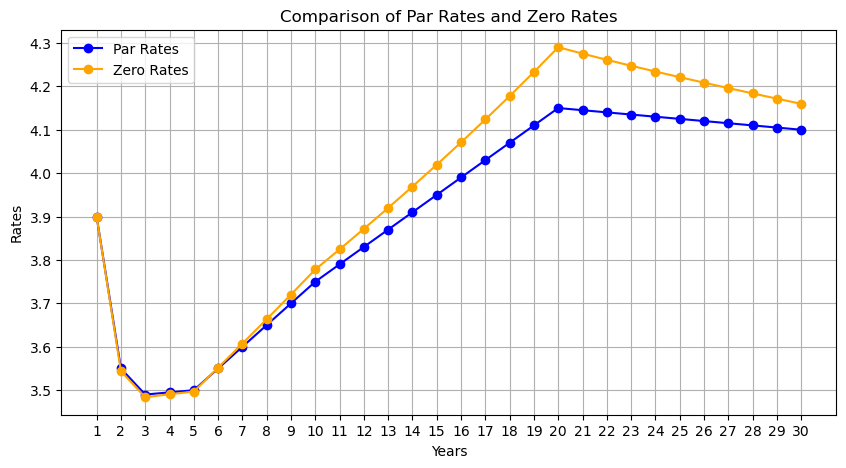

In [30]:
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

# Load CSV file into a DataFrame
file_path = r'OneDrive-IllinoisInstituteofTechnology/Financial Derivatives/daily-treasury-rates.csv'

data = pd.read_csv(file_path)

# Preview the data
print(data.head())

slice = data.loc[data.Date=='9/27/2024'].set_index('Date')  #'1/1/2025'

maturity_texts = np.array(slice.columns)
par_yields = np.array(slice.iloc[0].values)

def convert_maturity(text):
    text=text.replace(" ", "")
    if 'Mo' in text:
        return int(text[:-2]) / 12  # Convert months to years
    elif 'Yr' in text:
        return int(text[:-2])  # Years remain the same
    else:
        raise ValueError("Invalid maturity format")

maturities = np.array([convert_maturity(m) for m in maturity_texts])

maturities = np.array([convert_maturity(m) for m in maturity_texts])

# Get only Yearly yields
yearly_maturities = maturities[maturities >= 1]
yearly_yields = par_yields[maturities >= 1]

# Interpolation function for yearly rates
interp_function = interp1d(yearly_maturities, yearly_yields, kind='linear', fill_value='extrapolate')

# Define new yearly maturity values (every year from 1 to 30)
new_yearly_maturities = np.arange(1, 31)  # Years from 1 to 30
interpolated_yearly_yields = interp_function(new_yearly_maturities)

def bootstrap_zero_rates(par_rates):
    """
    Calculate zero-coupon rates for different maturities using bootstrapping.

    Parameters:
    par_rates (dict): A dictionary with keys as the maturity (in years) and values as the par rates.

    Returns:
    dict: A dictionary with maturities as keys and corresponding zero rates as values.
    """
    zero_rates = {}

    # Iterate through each maturity to calculate the zero rate
    for T in sorted(par_rates.keys()):
        # Calculate the left-hand side of the equation
        sum_of_discounted_coupons = sum(
            par_rates[T] / (1 + zero_rates[t]) ** t for t in range(1, T)
        )
        
        # Use the bootstrapping formula to calculate r_T
        r_T = ((100 + par_rates[T]) / (100 - sum_of_discounted_coupons)) ** (1 / T) - 1
        zero_rates[T] = r_T  # Store the calculated zero rate for maturity T

    return zero_rates

# Convert to dictionary
par_rates = dict(zip(new_yearly_maturities, interpolated_yearly_yields))

# Calculate zero rates
zero_rates = bootstrap_zero_rates(par_rates)

# Prepare data for plotting
years_list = list(par_rates.keys())
par_rates_list = list(par_rates.values())
zero_rates_list = [zero_rates[year]*100 for year in years_list]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(years_list, par_rates_list, marker='o', label='Par Rates', color='blue')
plt.plot(years_list, zero_rates_list, marker='o', label='Zero Rates', color='orange')
plt.title('Comparison of Par Rates and Zero Rates')
plt.xlabel('Years')
plt.ylabel('Rates')
plt.xticks(years_list)  # Set x-ticks to years
plt.grid()
plt.legend()
plt.show()

## USING XML

Previously, the data was manually sourced from a CSV file, handling of static files. Now, this process leverages an XML feed provided by the U.S. Department of the Treasury, allowing for real-time access to daily Treasury yield curve rates.

Changes (Dynamic Date Filtering, Data Conversion and Renaming - to match the type of the code, Error Handling for Date Availability - XML seems to be accurate just from 2023)

Changes 2: Check for missing columns and add NaN, Check for different dataTypes and converte since <2023 datatypes changes.


Filtered data for date:             1 Mo  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  \
Date                                                                            
2024-09-27   4.9  4.87  4.68  4.64  4.35   3.9  3.55  3.49   3.5   3.6   3.75   

            20 Yr  30 Yr  30 Yr Display  
Date                                     
2024-09-27   4.15    4.1            4.1  


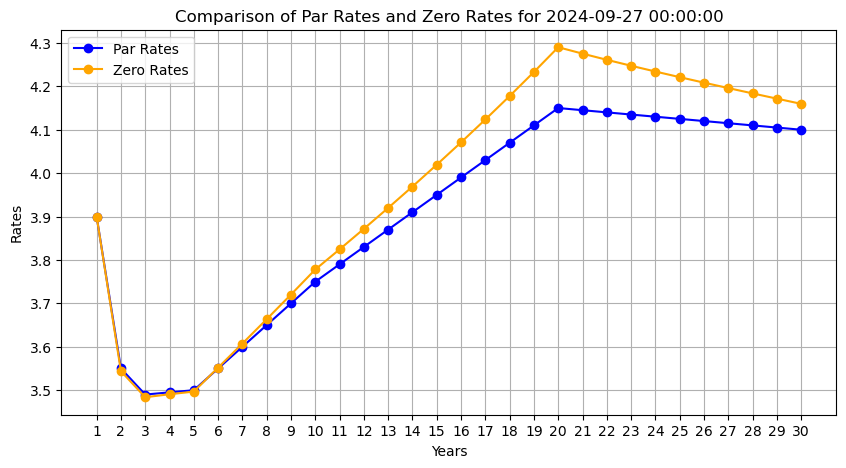

In [32]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Set year and target date
setYear = 2024
date_filter = pd.to_datetime(f"{setYear}-09-27")  # Target date in datetime format
url = f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value={setYear}"
response = requests.get(url)
root = ET.fromstring(response.content)

# Define namespaces
namespaces = {
    'd': 'http://schemas.microsoft.com/ado/2007/08/dataservices',
    'm': 'http://schemas.microsoft.com/ado/2007/08/dataservices/metadata',
    'atom': 'http://www.w3.org/2005/Atom'
}


# Parse XML into a DataFrame with explicit None checks to avoid deprecation warnings
data_records = [
    {element.tag.split('}')[-1]: element.text for element in properties}
    for entry in root.findall("atom:entry", namespaces)
    if (content := entry.find("atom:content", namespaces)) is not None
    if (properties := content.find("m:properties", namespaces)) is not None
]


# Proceed only if data was extracted
if data_records:
    data = pd.DataFrame(data_records)
    
    # Convert dates and numeric columns in a single step
    data['NEW_DATE'] = pd.to_datetime(data['NEW_DATE'], errors='coerce')
    # Define expected yield columns
    yield_columns = [
        'BC_1MONTH', 'BC_2MONTH', 'BC_3MONTH', 'BC_4MONTH', 'BC_6MONTH',
        'BC_1YEAR', 'BC_2YEAR', 'BC_3YEAR', 'BC_5YEAR', 'BC_7YEAR',
        'BC_10YEAR', 'BC_20YEAR', 'BC_30YEAR', 'BC_30YEARDISPLAY'
    ]
    
    # Keep only the yield columns that exist in the data
    available_yield_columns = [col for col in yield_columns if col in data.columns]
    
    # Convert existing yield columns to numeric
    data[available_yield_columns] = data[available_yield_columns].apply(pd.to_numeric, errors='coerce')

    # Rename columns directly during DataFrame manipulation
    rename_dict = {
        'NEW_DATE': 'Date',
        'BC_1MONTH': '1 Mo', 'BC_2MONTH': '2 Mo', 'BC_3MONTH': '3 Mo', 'BC_4MONTH': '4 Mo', 'BC_6MONTH': '6 Mo',
        'BC_1YEAR': '1 Yr', 'BC_2YEAR': '2 Yr', 'BC_3YEAR': '3 Yr', 'BC_5YEAR': '5 Yr', 'BC_7YEAR': '7 Yr',
        'BC_10YEAR': '10 Yr', 'BC_20YEAR': '20 Yr', 'BC_30YEAR': '30 Yr', 'BC_30YEARDISPLAY': '30 Yr Display'
    }
    data.rename(columns=rename_dict, inplace=True)

    # print("Available dates in data:", data['Date'].dropna().dt.strftime('%Y-%m-%d').unique())

    slice = data.query("Date == @date_filter").set_index('Date')

    # Check data (date)
    if slice.empty:
        print(f"No data available for {date_filter.strftime('%Y-%m-%d')}.")
    else:
        print("Filtered data for date:", slice)
    # Filter only columns with yield maturities
    maturity_texts = [col for col in slice.columns if col not in ["Id", "Date", "30 Yr Display"]]
    
    # Convert par_yields array and check if both maturities and par_yields match in size
    par_yields = np.array(slice[maturity_texts].iloc[0].values)
    
    # Ensure only yield columns are processed (<2023 problems)
    def convert_maturity(text):
        text = text.replace(" ", "")
        if text[:-2].isdigit():
            return int(text[:-2]) / (12 if 'Mo' in text else 1)
        else:
            raise ValueError(f"Invalid maturity format: '{text}'")
    
    try:
        maturities = np.array([convert_maturity(m) for m in maturity_texts])
    except ValueError as e:
        print(e)  # Print any errors encountered

    
    # Proceed only if dimensions match
    if maturities.shape == par_yields.shape:
        yearly_maturities = maturities[maturities >= 1]
        yearly_yields = par_yields[maturities >= 1]
    
        # Interpolate yields for yearly maturities
        interp_function = interp1d(yearly_maturities, yearly_yields, kind='linear', fill_value='extrapolate')
        new_yearly_maturities = np.arange(1, 31)  # New maturities from 1 to 30 years
        interpolated_yearly_yields = interp_function(new_yearly_maturities)
    
        # Bootstrapping
        def bootstrap_zero_rates(par_rates):
            """
            Calculate zero-coupon rates for different maturities using bootstrapping.
        
            Parameters:
            par_rates (dict): A dictionary with keys as the maturity (in years) and values as the par rates.
        
            Returns:
            dict: A dictionary with maturities as keys and corresponding zero rates as values.
            """
            zero_rates = {}
            for T in sorted(par_rates.keys()):
                sum_of_discounted_coupons = sum(
                    par_rates[T] / (1 + zero_rates[t]) ** t for t in range(1, T)
                )
                r_T = ((100 + par_rates[T]) / (100 - sum_of_discounted_coupons)) ** (1 / T) - 1
                zero_rates[T] = r_T
            return zero_rates
    
        par_rates = dict(zip(new_yearly_maturities, interpolated_yearly_yields))
        zero_rates = bootstrap_zero_rates(par_rates)
    
        # Plotting
        years_list = list(par_rates.keys())
        par_rates_list = list(par_rates.values())
        zero_rates_list = [zero_rates[year] * 100 for year in years_list]
    
        plt.figure(figsize=(10, 5))
        plt.plot(years_list, par_rates_list, marker='o', label='Par Rates', color='blue')
        plt.plot(years_list, zero_rates_list, marker='o', label='Zero Rates', color='orange')
        plt.title(f'Comparison of Par Rates and Zero Rates for {date_filter}')
        plt.xlabel('Years')
        plt.ylabel('Rates')
        plt.xticks(years_list)
        plt.grid()
        plt.legend()
        plt.show()
    else:
        print("Mismatch in maturities and par_yields dimensions.") #<2023



## HW - Week 7 Comparison Models and Metrics on them

In [34]:
import numpy as np

# Real data from FRED for 2024-09-27
fred_yields_2024_09_27 = np.array([3.9558, 3.5650, 3.4088, 3.3747, 3.4050, 3.4700, 3.5535, 3.6466, 3.7445, 3.8440])
fred_maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Corresponding maturities in years

# Model data for 2024-09-27
model_yields_2024_09_27 = np.array([3.9, 3.55, 3.49, np.nan, 3.5, 3.6, 3.75])  # No data for some years
model_maturities = np.array([1, 2, 3, 5, 7, 10])

aligned_model_yields = []
aligned_fred_yields = []

for maturity in fred_maturities:
    if maturity in model_maturities:
        idx = np.where(model_maturities == maturity)[0][0]
        aligned_model_yields.append(model_yields_2024_09_27[idx])
        aligned_fred_yields.append(fred_yields_2024_09_27[np.where(fred_maturities == maturity)[0][0]])

# Convert aligned lists to arrays
aligned_model_yields = np.array(aligned_model_yields)
aligned_fred_yields = np.array(aligned_fred_yields)

# Filter out NaN values from both arrays
valid_indices = ~np.isnan(aligned_model_yields)
filtered_model_yields = aligned_model_yields[valid_indices]
filtered_fred_yields = aligned_fred_yields[valid_indices]

# Calculate MAD and RMSE
mad = np.mean(np.abs(filtered_model_yields - filtered_fred_yields)) 
rmse = np.sqrt(np.mean((filtered_model_yields - filtered_fred_yields) ** 2))  

# Output results
print("Filtered Model Yields:", filtered_model_yields)
print("Filtered FRED Yields:", filtered_fred_yields)
print("Mean Absolute Deviation (MAD):", mad)
print("Root Mean Square Error (RMSE):", rmse)


Filtered Model Yields: [3.9  3.55 3.49 3.5  3.6 ]
Filtered FRED Yields: [3.9558 3.565  3.4088 3.5535 3.844 ]
Mean Absolute Deviation (MAD): 0.08990000000000009
Root Mean Square Error (RMSE): 0.1202749599875219
